In [11]:
"""
TODO: 
    - Write baseline model as a class
    - Refactor pipeline code, moving feature classes into model.py, and data processing into data.py
    - Build training pipeline
    - Save model function
    - Plot demand for a BA with prediction for the next day's demand marked on it
"""

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from typing import Tuple

from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)
from feature_engine.encoding import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from src.model import forwardfill_missing_values
from src.paths import TRANSFORMED_DATA_DIR
from src.config import BAS

data = pd.read_csv(
    TRANSFORMED_DATA_DIR / "ts_tabular_2020_12_to_2025_2.csv", parse_dates=["datetime"]
)

# Clean up data
data = data[data["ba_code"].isin(BAS)]
# Forward filling NaNs
data = forwardfill_missing_values(data)

data.head()

,datetime,demand,ba_code
0,2020-12-01,75397.0,AECI
1,2020-12-02,71967.0,AECI
2,2020-12-03,69654.0,AECI
3,2020-12-04,67352.0,AECI
4,2020-12-05,65905.0,AECI


In [12]:
demand = data.copy()
demand.dtypes

datetime    datetime64[ns]
demand             float64
ba_code             object
dtype: object

In [13]:
class FeatureEngineerByBA(BaseEstimator, TransformerMixin):
    """
    Loops over the BAs and applies {transformer} to each time series, storing
    the fitted transformers in {fitted_transformers}.
    """
    def __init__(self, transformer):
        self.transformer = transformer
        self.fitted_transformers = {}
        
    def fit(self, X, y = None):
        for ba_code in X['ba_code'].unique():
            tmp = X.loc[X['ba_code'] == ba_code, :].copy()
            self.fitted_transformers[ba_code] = self.transformer.fit(tmp)
        return self
    
    def transform(self, X, y = None):
        output = pd.DataFrame()
        for ba_code in X['ba_code'].unique():
            tmp = X.loc[X['ba_code'] == ba_code, :].copy()
            tmp = self.fitted_transformers[ba_code].transform(tmp)
            tmp['ba_code'] = ba_code
            output = pd.concat([output, tmp])
        return output

class ScaleByBA(BaseEstimator, TransformerMixin):
    """
    Loops over the BAs and applies {scaler} to each time series, storing
    the fitted scalers in {fitted_scalers}. Is only applied to target column 
    (demand) and features derived from it. 
    """
    def __init__(self, scaler):
        self.scaler = scaler
        self.fitted_scalers = {}

    def fit(self, X, y = None):
        demand_cols = X.filter(like="demand").columns
        for ba_code in X["ba_code"].unique():
            tmp = X.loc[X['ba_code'] == ba_code, demand_cols].copy()
            self.fitted_scalers[ba_code] = self.scaler.__class__().set_output(transform="pandas").fit(tmp)
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        output = pd.DataFrame()
        demand_cols = X.filter(like="demand").columns
        for ba_code in X['ba_code'].unique():
            tmp = X.loc[X["ba_code"] == ba_code, demand_cols].copy()
            tmp = self.fitted_scalers[ba_code].transform(tmp)
            output = pd.concat([output, tmp])
        X_[demand_cols] = output[demand_cols]
        return X_

In [14]:
demand = data.copy()

def make_pipeline():
    dtf = DatetimeFeatures(
        variables=["datetime"],
        features_to_extract=[
            "month",
            "week",
            "day_of_week",
            "day_of_month",
            "weekend",
        ],
        drop_original=False,
    )

    lag_transformer = FeatureEngineerByBA(
        LagFeatures(
            variables=["demand"],
            periods=[1, 2, 3, 4, 5, 6, 7, 30, 180, 365],
            drop_original=False,
        )
    )

    window_transformer = FeatureEngineerByBA(
        WindowFeatures(
            variables=["demand"], 
            window=[3, 7, 14], 
            freq=None, 
            functions=["mean", "std", "max", "min"],
            missing_values="ignore",
            )
        )

    minmax_scaler = ScaleByBA(
        MinMaxScaler()
        )

    # Introduce missing date when using lags and windows so need to drop these NaNs
    drop_missing = DropMissingData()

    # Ordinal encoding for BA feature
    ordinal_enc = OrdinalEncoder(variables=["ba_code"], encoding_method="arbitrary")

    # Also drop the target from the training set
    drop_target = DropFeatures(features_to_drop=["demand", "datetime"])

    pipe = Pipeline(
        [
            ("datetime", dtf),
            ("lags", lag_transformer),
            ("windf", window_transformer),
            ("minmax_scaling", minmax_scaler),
            ("drop_missing", drop_missing),
            ("ordinal_enc", ordinal_enc),
            ("drop_target", drop_target),
        ]
    )
    
    return pipe

pipe = make_pipeline()

demand_ = pipe.fit_transform(demand)
demand_.head()

,ba_code,datetime_month,datetime_week,datetime_day_of_week,datetime_day_of_month,datetime_weekend,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,demand_lag_30,demand_lag_180,demand_lag_365,demand_window_3_mean,demand_window_3_std,demand_window_3_max,demand_window_3_min,demand_window_7_mean,demand_window_7_std,demand_window_7_max,demand_window_7_min,demand_window_14_mean,demand_window_14_std,demand_window_14_max,demand_window_14_min
365,0,12,48,2,1,0,0.177929,0.240206,0.206548,0.220167,0.302662,0.229606,0.200568,0.206748,0.166380,0.309090,0.212896,0.110201,0.217950,0.203300,0.264808,0.137620,0.275050,0.271502,0.291305,0.151856,0.266279,0.280254
366,0,12,48,3,2,0,0.158780,0.177929,0.240206,0.206548,0.220167,0.302662,0.229606,0.200728,0.174980,0.273365,0.195246,0.151259,0.217950,0.181420,0.256855,0.164275,0.275050,0.242283,0.294173,0.139788,0.266279,0.334598
367,0,12,48,4,3,0,0.140522,0.158780,0.177929,0.240206,0.206548,0.220167,0.302662,0.211907,0.177859,0.249274,0.158415,0.065307,0.153849,0.160558,0.239899,0.195958,0.275050,0.214422,0.283416,0.158208,0.266279,0.296121
368,0,12,48,5,4,1,0.130272,0.140522,0.158780,0.177929,0.240206,0.206548,0.220167,0.220297,0.182659,0.225297,0.140806,0.049948,0.134140,0.148847,0.207087,0.145065,0.210121,0.198782,0.263474,0.149215,0.258958,0.274522
369,0,12,48,6,5,1,0.152581,0.130272,0.140522,0.158780,0.177929,0.240206,0.206548,0.221817,0.199688,0.210226,0.138515,0.038158,0.127758,0.148847,0.194223,0.135202,0.210121,0.198782,0.259493,0.156077,0.258958,0.274522


In [6]:
def split_data(
    df: pd.DataFrame, 
    train_end: str, 
    days_of_historic_data: int) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits data into training and test sets. Training set is from the earliest date
    in {df} to {train_end}. The test set is from {days_of_historic data} before {train_end} 
    to the latest date in {df}.
    
    Args:
        df: The data to split
        train_end: The date at which the data is split
        days_of_historic_data: The number of days before {train_end} that are required to make
            predictions on the test set
            
    Returns:
        Tuple containing targets and features for the training and test sets
    """

    data = df.copy()

    train_end = pd.Timestamp(train_end)

    X_train = data.loc[data["datetime"] < train_end]
    X_test = data.loc[
        data["datetime"] >= train_end - pd.offsets.Day(days_of_historic_data)
    ]

    y_train = data.loc[data["datetime"] < train_end]["demand"]
    y_test = data.loc[
        data["datetime"] >= train_end - pd.offsets.Day(days_of_historic_data)
    ]["demand"]

    print(f"Data successfully split at {train_end.date()}:")
    print(f"\t{X_train.shape=}: {X_train['datetime'].min().strftime('%Y-%m-%d')} --- {X_train['datetime'].max().strftime('%Y-%m-%d')}")
    print(
        f"\t{y_train.shape=}"
    )
    print(
        f"\t{X_test.shape=}: {X_test['datetime'].min().strftime('%Y-%m-%d')} --- {X_test['datetime'].max().strftime('%Y-%m-%d')}"
    )
    print(
        f"\t{y_test.shape=}"
    )

    return X_train, y_train, X_test, y_test

In [7]:
def transform_training_data(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    preprocessing_pipeline: Pipeline) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Applies {preprocessing_pipeline} of transformations to the train and test sets for training and 
    validation.

    Args:
        X_train: Training features 
        y_train: Training target
        X_test: Test features
        y_test: Test target
        
    Returns:
        Tuple containing transformed targets and features for the train and test sets.
    """

    # Fit and transform train set
    X_train_t = preprocessing_pipeline.fit_transform(X_train)
    # Align indexes
    y_train_t = y_train.loc[X_train_t.index]

    # Transform test set
    X_test_t = preprocessing_pipeline.transform(X_test)
    # Align indexes
    y_test_t = y_test.loc[X_test_t.index]

    assert all(y_train_t.index == X_train_t.index), "Indexes of target don't match features in training set"
    assert all(y_test_t.index == X_test_t.index), "Indexes of target don't match features in testing set"

    return X_train_t, y_train_t, X_test_t, y_test_t

In [8]:
def plot_predictions_against_actuals(train_pred: pd.Series, train_actual: pd.Series, test_pred: pd.Series, test_actual: pd.Series):
    """
    Plots residuals for training and test sets.

    Args:
        train_pred: Predictions for training set
        train_actual: Actual values for training set
        test_pred: Predictions for test set
        test_actual: Actual values for test set
    """
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    ax1.scatter(
        test_pred,
        test_actual,
        c="limegreen",
        marker="s",
        edgecolor="white",
        label="Test data",
    )
    ax2.scatter(
        train_pred,
        train_actual,
        c="steelblue",
        marker="o",
        edgecolor="white",
        label="Training data",
    )
    ax1.set_ylabel("Actual values")
    for ax in (ax1, ax2):
        ax.set_xlabel("Predicted values")
        ax.legend(loc="upper left")
    plt.suptitle("Predicted vs Actual Values")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_residuals(train_pred: pd.Series, train_actual: pd.Series, test_pred: pd.Series, test_actual: pd.Series):
    """
    Plots residuals for training and test sets.

    Args:
        train_pred: Predictions for training set
        train_actual: Actual values for training set
        test_pred: Predictions for test set
        test_actual: Actual values for test set
    """
    x_max = np.max(
        [np.max(train_pred), np.max(test_pred)])
    x_min = np.min(
        [np.min(train_pred), np.min(test_pred)])
    _, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(8, 4), sharey=True)
    ax1.scatter(
        test_pred, test_pred - test_actual,
        c='limegreen', marker='s',
        edgecolor='white',
        label='Test data')
    ax2.scatter(
        train_pred, train_pred - train_actual,
        c='steelblue', marker='o', edgecolor='white',
        label='Training data')
    ax1.set_ylabel('Residuals')
    for ax in (ax1, ax2):
        ax.set_xlabel('Predicted values')
        ax.legend(loc='upper left')
        ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,\
            color='black', lw=2)
    plt.suptitle("Residual Plots")
    plt.tight_layout()
    plt.show() 

Data successfully split at 2024-01-01:
	X_train.shape=(59678, 3): 2020-12-01 --- 2023-12-31
	y_train.shape=(59678,)
	X_test.shape=(41764, 3): 2023-01-01 --- 2025-02-26
	y_test.shape=(41764,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5770
[LightGBM] [Info] Number of data points in the train set: 40333, number of used features: 28
[LightGBM] [Info] Start training from score 211952.059529
Training score:	11962.26769341702
Test score:	14439.603931228048


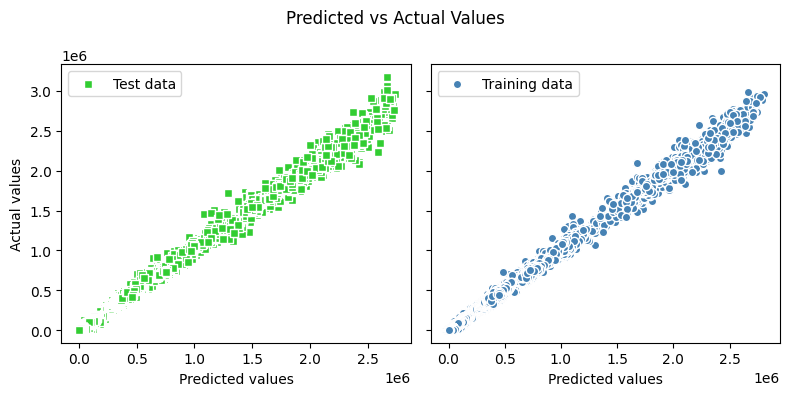

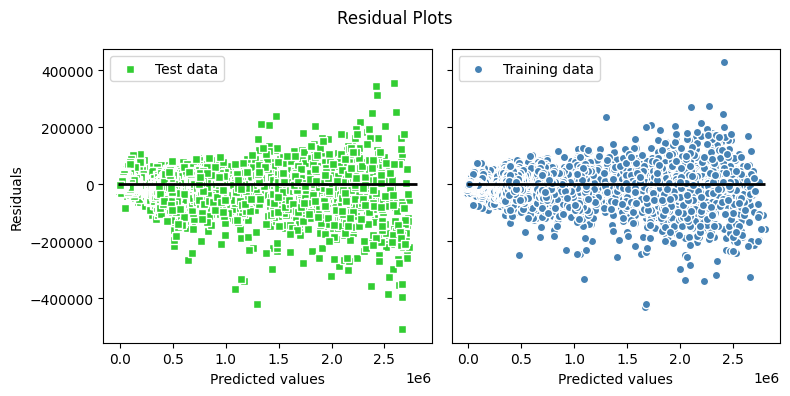

In [ ]:
# Training pipeline

# 0. Constants
train_end = "2024-01-01"
days_of_historic_data = 365

# 1. Split Data
X_train, y_train, X_test, y_test = split_data(
    data, train_end=train_end, days_of_historic_data=days_of_historic_data
)

# 2. Transform Data
pipe = Pipeline(
    [
        ("datetime", dtf),
        ("lags", lag_transformer),
        ("windf", window_transformer),
        ("minmax_scaling", minmax_scaler),
        ("drop_missing", drop_missing),
        ("ordinal_enc", ordinal_enc),
        ("drop_target", drop_target),
    ]
)

X_train_t, y_train_t, X_test_t, y_test_t = transform_training_data(
    X_train, y_train, X_test, y_test, pipe
)

# 3. Train model
lgbm = LGBMRegressor()

lgbm.fit(X_train_t, y_train_t)

# 4. Evaluate model
preds_train = lgbm.predict(X_train_t)
preds_test = lgbm.predict(X_test_t)

mae_train = mean_absolute_error(preds_train, y_train_t)
mae_test = mean_absolute_error(preds_test, y_test_t)

print(f"Training score:\t{mae_train}")
print(f"Test score:\t{mae_test}")

plot_predictions_against_actuals(preds_train, y_train_t, preds_test, y_test_t)
plot_residuals(preds_train, y_train_t, preds_test, y_test_t)